In [1]:
import dedalus_sphere.zernike as Zernike
import dedalus_sphere.jacobi as Jacobi

import numpy as np
import scipy as sp
import scipy.linalg
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib notebook

np.set_printoptions(precision=3,suppress=True)

# Add '../' to path
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from kronecker import Kronecker
from stretched_sphere import make_square_resizer, laplacian, laplacian_correction, zernike_operator
    
# Common operators
dim = 2
Ds = Zernike.operator(dim, 'D')
E = Zernike.operator(dim, 'E')
R = Zernike.operator(dim, 'R')
IdR = Zernike.operator(dim, 'Id')

A = Jacobi.operator('A')
B = Jacobi.operator('B')
C = Jacobi.operator('C')
Dz = Jacobi.operator('D')
Z = Jacobi.operator('Z')
IdZ = Jacobi.operator('Id')

# Composite operators
H = IdR - R(-1) @ R(+1)
# RdR = 1/2*(R(+1) @ Ds(-1) + R(-1) @ Ds(+1))
RdR = zernike_operator(dim, 'RdR')
ZdZ = Z @ Dz(+1)
S2 = R(-1) @ R(+1)
H2 = H**2
Z2 = Z**2
AB = A(+1) @ B(+1)


We expand our cylindrical-radial $0 \le s \le 1$ and vertical dependence $-1 \le \eta \le 1$ into a series for fixed azimuthal mode $m$ as
$$ f_m(s,\eta) = \sum_{n=0}^{N_{max}} \sum_{l=0}^{L_{max}} F^m_{n,l} Q_n^{k,m}(s) T_l(\eta) , $$
where $T_l$ are Jacobi polynomials of the first kind and $Q_n^{k,m}$ are the Zernike polynomials related to the Jacobi polynomials by
$$ Q_n^{k,m}(s) \sim s^m P_n^{k,m} \left(2 s^2 - 1\right). $$
Our spectral expansion coefficients are given by $F^m_{n,l}$.

Note that we are free to select $k$ and are in no sense bound to using Chebyshev polynomials $T_l$.

In [2]:
def plotfield(s, eta, f):
    fig, ax = plt.subplots(figsize=(7,4))
    im = ax.pcolormesh(s, eta, f)
    fig.colorbar(im, ax=ax)
    ax.set_xlabel('s')
    ax.set_ylabel('η')

def expansion(F, T, Q):
    return T @ (Q @ F).T



In [3]:
m, Nmax, Lmax = 3, 8, 4
a, b, k = -1/2, -1/2, 0
ns, neta = 1000, 2000

# Construct the basis polynomials
s, eta = np.linspace(0,1,ns+1)[1:], np.linspace(-1,1,neta)
sgrid, etagrid = np.reshape(s, (1,ns)), np.reshape(eta, (neta,1))
z = 2*s**2 - 1
Qn = Zernike.polynomials(dim,Nmax,k,m,z).T
Tn = Jacobi.polynomials(Lmax,a,b,eta).T

# Spectral expansion coefficients
# F = sp.linalg.hilbert(max(Nmax,Lmax))
# F = F[:Nmax,:Lmax]
F = np.zeros((Nmax,Lmax))
F[:,1] = 0.1
F[:,2] = 1
F[:,3] = 0.1
F[1,:] *= 2
f = expansion(F, Tn, Qn)


# Multiply by eta*(1-s**2)**2
Qnop = Zernike.polynomials(dim,Nmax+2,k,m,z).T
Tnop = Jacobi.polynomials(Lmax+1,a,b,eta).T
Fop = (Z(Lmax,a,b) @ ((H @ H)(Nmax,k,m) @ F).T).T
fop = expansion(Fop, Tnop, Qnop)
fgrid = etagrid*(1-sgrid**2)**2*f
error = fgrid - fop
assert np.max(abs(error)) < 1.2e-15


# Multiply by eta*(1-s**2)**2, matrix form
op = sparse.kron((H @ H)(Nmax,k,m), Z(Lmax,a,b))

# Apply the operator
Fop2 = np.reshape(op @ F.ravel(), (Nmax+2,Lmax+1))
fop2 = expansion(Fop2, Tnop, Qnop)

error = np.max(abs(fop-fop2))
assert error < 1e-15


# Operator: S**2 * Z**2
S2 = R(-1) @ R(+1)
Z2 = Z**2
ops = S2
opz = Z2
op = sparse.kron(S2(Nmax,k,m), Z2(Lmax,a,b))

F = np.ones((Nmax,Lmax))
f = expansion(F, Tn, Qn)

Fop = np.reshape(op @ F.ravel(), (Nmax+1,Lmax+2))
Qop = Zernike.polynomials(dim,Nmax+1,k,m,z).T
Top = Jacobi.polynomials(Lmax+2,a,b,eta).T
fop = expansion(Fop, Top, Qop)

fgrid = sgrid**2*etagrid**2*f
error = fgrid - fop
assert np.max(abs(error)) < 5e-14


In [4]:
# Construct the radial component of gradient of pressure
m, Nmax, Lmax = 3, 100, 10
a, b, k = -1/2, -1/2, 0
ns, neta = 1000, 2000

# Construct the basis polynomials
s, eta = np.linspace(0,1,ns+1)[1:], np.linspace(-1,1,neta)
z = 2*s**2 - 1
Qn = Zernike.polynomials(dim,Nmax,k,m,z).T
Tn = Jacobi.polynomials(Lmax,a,b,eta).T

# Spectral expansion coefficients
# F = sp.linalg.hilbert(max(Nmax,Lmax))
# F = F[:Nmax,:Lmax]
F = np.zeros((Nmax,Lmax))
F[:,1] = 0.1
F[:,2] = 1
F[:,3] = 0.1
F[1,:] *= 2
f = expansion(F, Tn, Qn)


# S*(H**2)*(S*d/dS)
RdR = 1/2*(R(+1) @ Ds(-1) + R(-1) @ Ds(+1))
ZdZ = Z @ Dz(+1)

op1s = R(+1) @ H**2 @ RdR   # r*(1-r**2)**2*r*d/dr
op1z = A(+1) @ B(+1)        # Tn -> Un
op1 = sparse.kron(op1s(Nmax,k,m)[:Nmax,:], op1z(Lmax, a, b)[:,:Lmax])

op2s = E(+1) @ R(+1) @ R(-1) @ R(+1) @ H  # r**3*(1-r**2)
op2z = Z @ Dz(+1)                         # z*d/dz
op2 = sparse.kron(op2s(Nmax,k,m)[:Nmax,:], op2z(Lmax,a,b)[:,:Lmax])

assert op1s.codomain == op2s.codomain
assert op1z.codomain == op2z.codomain


# R*d/dR * eta*d/deta
ops = RdR
opz = Z @ Dz(+1)
op1 = sparse.kron(ops(Nmax,k,m)[:Nmax,:], opz(Lmax,a,b)[:,:Lmax])
op2a = sparse.kron(ops(Nmax,k,m)[:Nmax,:], IdZ(Lmax,a,b))
op2b = sparse.kron(IdR(Nmax,k,m), opz(Lmax,a,b)[:,:Lmax])
op2 = op2a @ op2b

assert np.max(abs(op2-op1)) < 1e-16


<IPython.core.display.Javascript object>


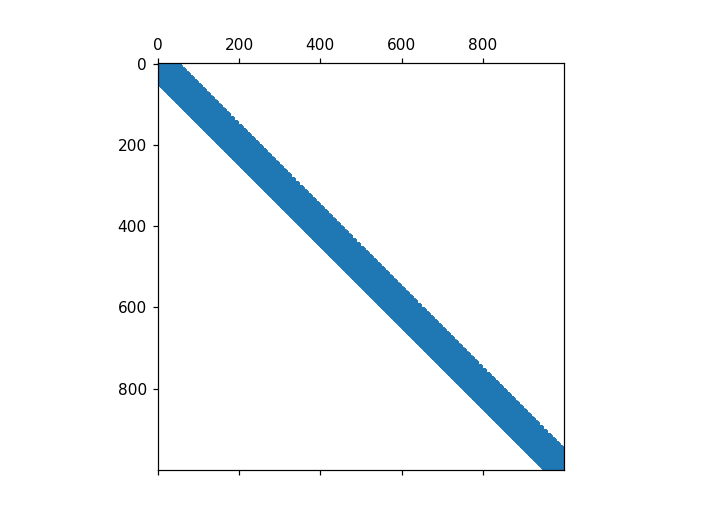

<IPython.core.display.Javascript object>


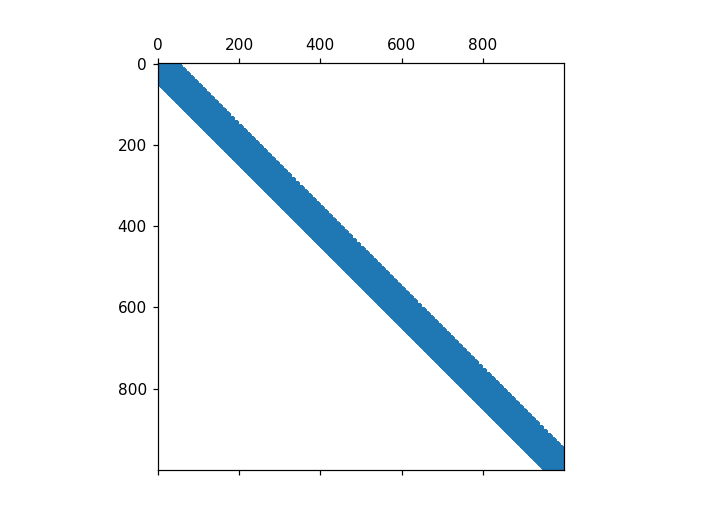

(1010, 1000)
(1010, 1000)
(909, 1000)
(n->n+1,k->k+1,l->l)
(n->n+1,k->k+1,l->l)
(n->n,a->a+1,b->b+1)
(n->n,a->a+1,b->b+1)
(n->n+1,k->k+1,l->l)
(n->n,a->a+1,b->b+1)
(n->n+1,k->k+1,l->l-1)
(n->n-1,a->a+1,b->b+1)


In [5]:
# Laplacian-type tors
m, Nmax, Lmax = 3, 100, 10
a, b, k = -1/2, -1/2, 0
ns, neta = 1000, 2000

# Construct the basis polynomials
s, eta = np.linspace(0,1,ns+1)[1:], np.linspace(-1,1,neta)
z = 2*s**2 - 1
Qn = Zernike.polynomials(dim,Nmax,k,m,z).T
Tn = Jacobi.polynomials(Lmax,a,b,eta).T

# Spectral expansion coefficients
# F = sp.linalg.hilbert(max(Nmax,Lmax))
# F = F[:Nmax,:Lmax]
F = np.zeros((Nmax,Lmax))
F[:,1] = 0.1
F[:,2] = 1
F[:,3] = 0.1
F[1,:] *= 2
f = expansion(F, Tn, Qn)

resizer = make_square_resizer([Nmax, Lmax])

# Scaled Laplacian and correction for Lap(h*w)
Lop = laplacian(resizer)
Aop = laplacian_correction(resizer)

plt.figure(); plt.spy(Lop([(Nmax,k,m),(Lmax,a,b)]))
plt.figure(); plt.spy(Aop([(Nmax,k,m),(Lmax,a,b)]))


# Divergence equation
L40s1 = H @ (E(+1) + RdR)
L40s2 = E(+1) @ S2
L40z1 = AB
L40z2 = ZdZ
L401 = sparse.kron(L40s1(Nmax,k,m-1),L40z1(Lmax,a,b))
L402 = sparse.kron(L40s2(Nmax,k,m-1),L40z2(Lmax,a,b))
L40 = L401 + L402
print(np.shape(L40))

L41s = E(+1) @ H
L41z = AB
L41 = 1j*m * sparse.kron(L41s(Nmax,k,m-1),L41z(Lmax,a,b))
print(np.shape(L41))

L42s = E(+1) @ R(-1)
L42z = Dz(+1)
L42 = sparse.kron(L42s(Nmax,k,m),L42z(Lmax,a,b))
print(np.shape(L42))

print(L40s1.codomain)
print(L40s2.codomain)
print(L40z1.codomain)
print(L40z2.codomain)

print(L41s.codomain)
print(L41z.codomain)

print(L42s.codomain)
print(L42z.codomain)


<IPython.core.display.Javascript object>


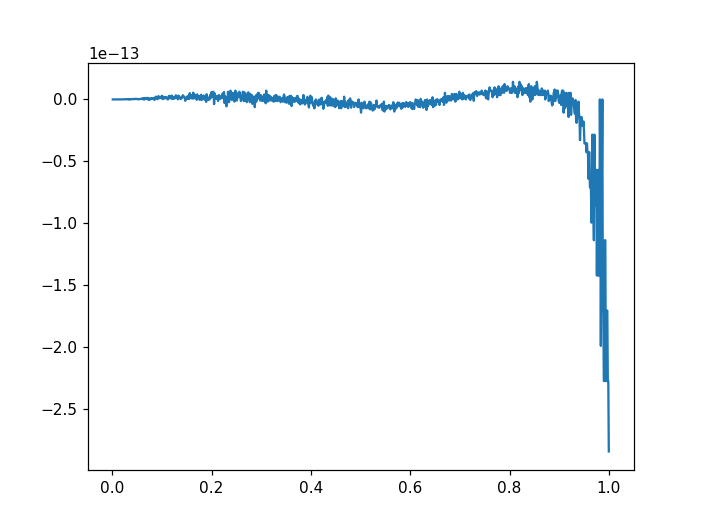

In [6]:
# Mixed boundary conditions
m, Nmax, Lmax = 3, 6, 5
a, b, k = 0, 0, 1/2
ns, neta = 1000, 2001

etas = np.array([1.])
nbc = len(etas)
bc = Jacobi.polynomials(Lmax,a,b,etas).T

eta = np.linspace(-1,1,neta)
s = np.linspace(0,1,ns+1)[1:]
z = 2*s**2 - 1
Tn = Jacobi.polynomials(Lmax,a,b,eta).T
Pn = Zernike.polynomials(dim,Nmax,k,m,z).T

fcoeff = np.ones((Nmax,Lmax))
fgrid = expansion(fcoeff, Tn, Pn)
sf = s*fgrid[-1,:]

B = sparse.kron(R(+1)(Nmax,k,m), bc)
scoeff = B @ fcoeff.ravel()
Pn = Zernike.polynomials(dim,Nmax,k,m+1,z).T
sgrid = Pn @ scoeff
assert np.max(abs(sf-sgrid)) < 5e-13

B = sparse.kron(R(-1)(Nmax,k,m), bc)
scoeff = B @ fcoeff.ravel()
Pn = Zernike.polynomials(dim,Nmax+1,k,m-1,z).T
sgrid = Pn @ scoeff
assert np.max(abs(sf-sgrid)) < 5e-13

S = sparse.hstack([R(-1)(Nmax,k,m), np.zeros((Nmax+1,1))])
B = sparse.kron(S, bc)
fpad = np.vstack([fcoeff,np.zeros((1,Lmax))])
scoeff = B @ fpad.ravel()
Pn = Zernike.polynomials(dim,Nmax+1,k,m-1,z).T
sgrid = Pn @ scoeff
assert np.max(abs(sf-sgrid)) < 5e-13

plt.figure()
plt.plot(s,sf-sgrid)

In [8]:
print('Success!')

Success!
